# **Banxico EDA**

Las variables extraídas de Banxico, que incluyen el tipo de cambio del dólar, el valor de las UDIs, la 
tasa de referencia, la TIIE a 28 días y los CETES a 28 días, fueron analizadas siguiendo la misma 
metodología previamente aplicada al índice IPC 

In [88]:
# Importar librerias
import pandas as pd
import numpy as np
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import sys, os
ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(ROOT)
from utils.date import calendario_df, datetime_index
from scipy import stats
from scipy.stats import jarque_bera
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


In [3]:
df_banxico = pd.read_csv("../raw/banxico_history_2025-01-01_to_2025-08-31.csv")

In [4]:
df_banxico.columns = df_banxico.columns.str.replace("date", "Date", regex=False)

In [5]:
df_banxico

,Date,dolar_cambio,udis,tasa_ref,tiie_28,cetes_28
0,2019-12-30,18.8727,6.397616,7.25,7.5555,9.951659
1,2019-12-31,18.8642,6.399018,7.25,7.5550,9.953578
2,2020-01-01,NaN,6.400419,7.25,NaN,NaN
3,2020-01-02,18.8817,6.401821,7.25,7.5525,9.943954
4,2020-01-03,18.8673,6.403224,7.25,7.5495,9.945963
...,...,...,...,...,...,...
1475,2025-08-25,18.6368,8.539373,7.75,8.0226,9.948731
1476,2025-08-26,18.6843,8.539259,7.75,8.0126,9.950706
1477,2025-08-27,18.6912,8.539145,7.75,8.0226,9.952862
1478,2025-08-28,18.6522,8.539031,7.75,8.0327,9.940007


Generamos el calendario con las fechas faltantes para la serie, dando un resumen de las filas que se insertaron.

Teniendo df_ipc_f el calnedario completo, tanto dias operables como no opearables

In [6]:
df_ban_f, info_ban = calendario_df(df_banxico, date_col="Date")

In [7]:
info_ban

{'filas_originales': 1480,
 'filas_esperadas': 2072,
 'filas_insertadas': 592,
 'primer_falta': datetime.date(2020, 1, 4),
 'ultima_falta': datetime.date(2025, 8, 31)}

In [8]:
df_ban_f 
# DF con el calendario completo, dias operativos y no operativos

,Date,dolar_cambio,udis,tasa_ref,tiie_28,cetes_28
0,2019-12-30,18.8727,6.397616,7.25,7.5555,9.951659
1,2019-12-31,18.8642,6.399018,7.25,7.5550,9.953578
2,2020-01-01,NaN,6.400419,7.25,NaN,NaN
3,2020-01-02,18.8817,6.401821,7.25,7.5525,9.943954
4,2020-01-03,18.8673,6.403224,7.25,7.5495,9.945963
...,...,...,...,...,...,...
2067,2025-08-27,18.6912,8.539145,7.75,8.0226,9.952862
2068,2025-08-28,18.6522,8.539031,7.75,8.0327,9.940007
2069,2025-08-29,18.6440,8.538918,7.75,8.0327,9.942952
2070,2025-08-30,NaN,NaN,NaN,NaN,NaN


In [9]:
# Para calendario completo
df_ban_f = datetime_index(df_ban_f, date_col="Date", dayfirst=False)
# Para calendario de negociacion
df_banxico = datetime_index(df_banxico, date_col="Date", dayfirst=False)

In [10]:
df_ban_f

,dolar_cambio,udis,tasa_ref,tiie_28,cetes_28
Date,,,,,
2019-12-30,18.8727,6.397616,7.25,7.5555,9.951659
2019-12-31,18.8642,6.399018,7.25,7.5550,9.953578
2020-01-01,NaN,6.400419,7.25,NaN,NaN
2020-01-02,18.8817,6.401821,7.25,7.5525,9.943954
2020-01-03,18.8673,6.403224,7.25,7.5495,9.945963
...,...,...,...,...,...
2025-08-27,18.6912,8.539145,7.75,8.0226,9.952862
2025-08-28,18.6522,8.539031,7.75,8.0327,9.940007
2025-08-29,18.6440,8.538918,7.75,8.0327,9.942952


### **Analisis de Datos Faltantes**

In [11]:
def missing_weekday_weekend(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("El índice debe ser DatetimeIndex.")
    isna = df.isna()
    is_weekend = pd.Series(df.index.weekday >= 5, index=df.index)

    weekend_missing = (isna & is_weekend.values[:, None]).sum(axis=0)
    weekday_missing = (isna & (~is_weekend).values[:, None]).sum(axis=0)

    out = pd.DataFrame({
        "weekday_missing": weekday_missing.astype(int),
        "weekend_missing": weekend_missing.astype(int),
    })
    out["total_missing"] = out["weekday_missing"] + out["weekend_missing"]
    return out.sort_values("total_missing", ascending=False)

In [12]:
def plot_weekday_weekend_missing(df: pd.DataFrame):
    tbl = missing_weekday_weekend(df)
    x = np.arange(len(tbl.index))
    w = 0.4

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - w/2, tbl["weekday_missing"].values, width=w, label="Entre semana (L–V)")
    ax.bar(x + w/2, tbl["weekend_missing"].values, width=w, label="Fin de semana (S–D)")

    ax.set_xticks(x)
    ax.set_xticklabels(tbl.index, rotation=45, ha="right")
    ax.set_ylabel("Conteo de nulos")
    ax.set_title("Nulos por columna: Entre semana vs Fin de semana")
    ax.legend()
    plt.tight_layout()
    plt.show()
    return tbl

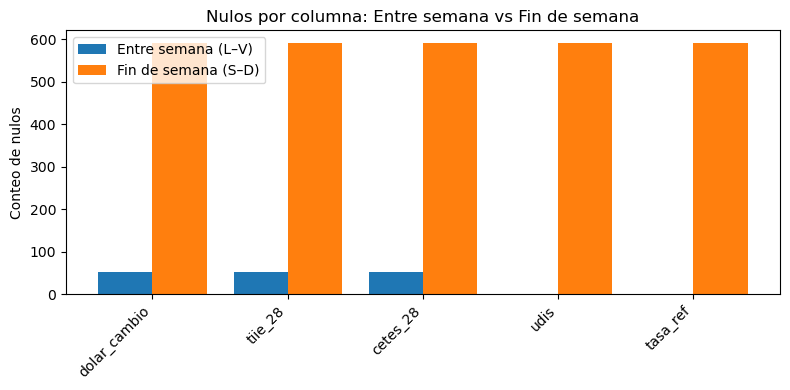

,weekday_missing,weekend_missing,total_missing
dolar_cambio,52,592,644
tiie_28,52,592,644
cetes_28,52,592,644
udis,0,592,592
tasa_ref,0,592,592


In [196]:
plot_weekday_weekend_missing(df_ban_f)

Para el análisis de días faltantes las series de dólar de cambio, tiie_28, cetes_28 el conteo de faltantes 
se concentra en fines de semana: se registran 592 nulos frente a 52 en días hábiles, para un total de 
644. Las series udis, tasa_ref no presentan datos faltantes en días 
hábiles, presentando 592 nulos en fines de semana. Por lo tanto, para las series udis y tasa_ref solo se 
aplicara el método de imputación forward-fill, por lo que solo se analizaran las demás variables

In [13]:
def missing_by_weekday_counts(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("El índice debe ser DatetimeIndex.")

    # Filtrar solo L–V
    df_biz = df[df.index.weekday < 5]
    isna = df_biz.isna()
    dow = df_biz.index.weekday  # 0..4

    counts = {}
    for col in df_biz.columns:
        c = pd.Series(dow[isna[col]].value_counts()).reindex(range(5), fill_value=0).astype(int)
        counts[col] = c

    counts_df = pd.DataFrame(counts).T
    counts_df.columns = ["Mon","Tue","Wed","Thu","Fri"]
    return counts_df

In [14]:
def plot_missing_by_weekday_counts(df: pd.DataFrame):
    
    counts_df = missing_by_weekday_counts(df)
    dow_labels = ["Mon","Tue","Wed","Thu","Fri"]

    for col in counts_df.index:
        fig, ax = plt.subplots(figsize=(6, 3.3))
        ax.bar(range(5), counts_df.loc[col].values)
        ax.set_xticks(range(5))
        ax.set_xticklabels(dow_labels)
        ax.set_title(f"Nulos por día (L–V): {col}")
        ax.set_xlabel("Día de la semana")
        ax.set_ylabel("Conteo de nulos")
        plt.tight_layout()
        plt.show()
    return counts_df

In [15]:
counts_df = missing_by_weekday_counts(df_ban_f)
counts_df

,Mon,Tue,Wed,Thu,Fri
dolar_cambio,23,3,6,10,10
udis,0,0,0,0,0
tasa_ref,0,0,0,0,0
tiie_28,23,3,6,10,10
cetes_28,23,3,6,10,10


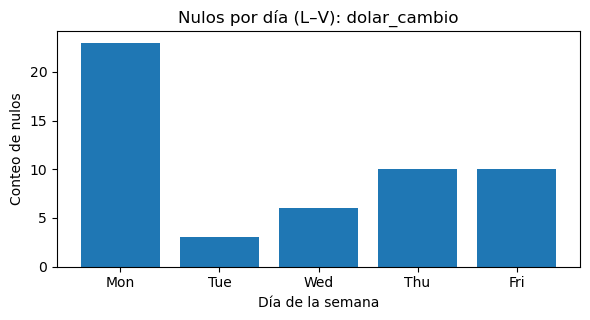

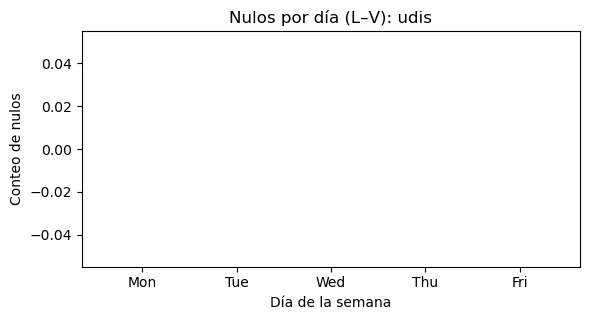

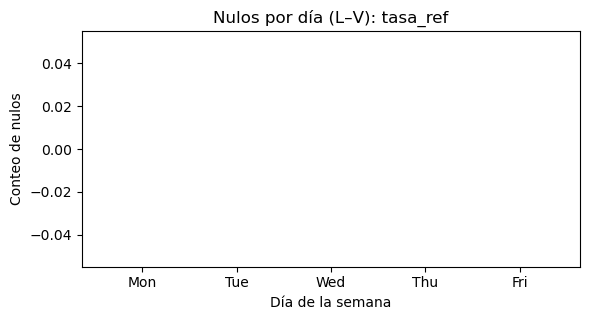

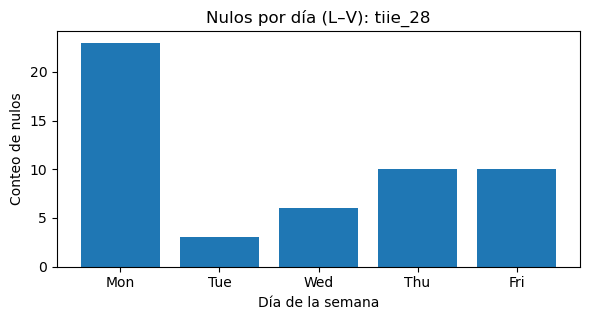

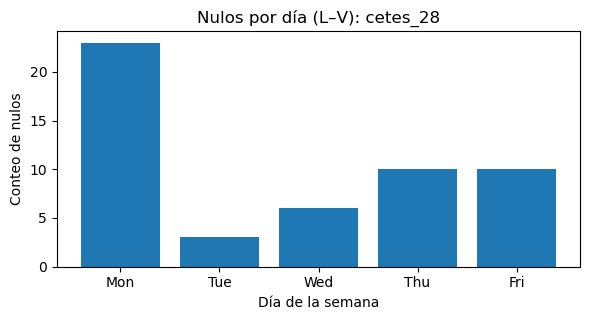

In [16]:
counts_df = plot_missing_by_weekday_counts(df_ban_f)

En días hábiles, para las series dólar_cambio, tiie_28 y cetes_28 la mayor incidencia ocurre los lunes 
con 23 nulos, martes 3, miércoles 6, jueves 10 y viernes 10

También se realizó un análisis que relacione los días habiles 
faltantes con los días festivos del calendario operativo, mostrando si los datos faltantes son aleatorios 
o estructurados dados por fechas festivas, como se ve en el siguiente codigo

In [ ]:
## SABER SI LOS NULOS APARECEN DE FORMA ALEATORIA O SISTEMATICA POR DIAS FERIADOS
null_days = df_ban_f[df_ban_f.isna().any(axis=1)]

# Filtrar solo días entre semana (0=lunes ... 4=viernes)
weekday_nulls = null_days[null_days.index.weekday < 5]
weekday_nulls.index


DatetimeIndex(['2020-01-01', '2020-02-03', '2020-03-16', '2020-04-09',
               '2020-04-10', '2020-05-01', '2020-09-16', '2020-11-02',
               '2020-11-16', '2020-12-25', '2021-01-01', '2021-02-01',
               '2021-03-15', '2021-04-01', '2021-04-02', '2021-09-16',
               '2021-11-02', '2021-11-15', '2022-02-07', '2022-03-21',
               '2022-04-14', '2022-04-15', '2022-09-16', '2022-11-02',
               '2022-11-21', '2022-12-12', '2023-02-06', '2023-03-20',
               '2023-04-06', '2023-04-07', '2023-05-01', '2023-11-02',
               '2023-11-20', '2023-12-12', '2023-12-25', '2024-01-01',
               '2024-02-05', '2024-03-18', '2024-03-28', '2024-03-29',
               '2024-05-01', '2024-09-16', '2024-10-01', '2024-11-18',
               '2024-12-12', '2024-12-25', '2025-01-01', '2025-02-03',
               '2025-03-17', '2025-04-17', '2025-04-18', '2025-05-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [17]:
def gaps_nan_corridas(df_or_series, value_col=None, solo_habiles=False):
  # 1) Obtener la serie s
    if isinstance(df_or_series, pd.DataFrame):
        if value_col is None:
            num_cols = df_or_series.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("Especifica 'value_col'; no hay columnas numéricas.")
            value_col = num_cols[0]
        s = df_or_series[value_col]
    else:
        s = df_or_series

    # Asegurar índice datetime diario y ordenado
    s = s.copy()
    s.index = pd.to_datetime(s.index).tz_localize(None).normalize()
    s = s.sort_index()

    # 2) Opcional: quedarse solo con días hábiles (L-V)
    if solo_habiles:
        s = s[s.index.weekday < 5]

    if s.empty:
        return (pd.DataFrame(columns=["inicio","fin","longitud","bucket"]),
                pd.Series({1:0,2:0,3:0,4:0,">=5":0}))

    # 3) Corridas de NaN: agrupar True consecutivos
    mask = s.isna()
    if not mask.any():
        return (pd.DataFrame(columns=["inicio","fin","longitud","bucket"]),
                pd.Series({1:0,2:0,3:0,4:0,">=5":0}))

    grp = mask.ne(mask.shift()).cumsum()          # id de bloque cada vez que cambia True/False
    sizes = mask.groupby(grp).size()              # tamaño de cada bloque
    is_nan = mask.groupby(grp).first()            # si el bloque es NaN o no

    runs = pd.DataFrame({"longitud": sizes, "es_nan": is_nan})
    runs = runs[runs["es_nan"]]                   # quedarnos con bloques de NaN

    # Obtener inicio y fin (fechas) de cada corrida
    idx_by_grp = s.index.to_series().groupby(grp)
    inicios = idx_by_grp.first()[runs.index]
    fines   = idx_by_grp.last()[runs.index]

    detalle = pd.DataFrame({
        "inicio": inicios.values,
        "fin": fines.values,
        "longitud": runs["longitud"].values
    }).sort_values("inicio").reset_index(drop=True)

    # 4) Buckets
    detalle["bucket"] = detalle["longitud"].apply(lambda k: k if k in {1,2,3,4} else ">=5")
    resumen = (detalle["bucket"].value_counts()
               .reindex([1,2,3,4,">=5"], fill_value=0)
               .astype(int))

    return detalle, resumen


In [18]:
df_ban_f

,dolar_cambio,udis,tasa_ref,tiie_28,cetes_28
Date,,,,,
2019-12-30,18.8727,6.397616,7.25,7.5555,9.951659
2019-12-31,18.8642,6.399018,7.25,7.5550,9.953578
2020-01-01,NaN,6.400419,7.25,NaN,NaN
2020-01-02,18.8817,6.401821,7.25,7.5525,9.943954
2020-01-03,18.8673,6.403224,7.25,7.5495,9.945963
...,...,...,...,...,...
2025-08-27,18.6912,8.539145,7.75,8.0226,9.952862
2025-08-28,18.6522,8.539031,7.75,8.0327,9.940007
2025-08-29,18.6440,8.538918,7.75,8.0327,9.942952


También se realizo un analisis de corridas del calendario, reportando la longitud de corridas para días habiles. Se reporta para cada variable

In [20]:
# Dolar de Cambio
detalle_biz, resumen_biz = gaps_nan_corridas(df_ban_f, value_col="dolar_cambio", solo_habiles=True)
# dolar cambio
resumen_biz

bucket
1      40
2       6
3       0
4       0
>=5     0
Name: count, dtype: int32

In [21]:
# cetes_28
detalle_biz, resumen_biz = gaps_nan_corridas(df_ban_f, value_col="cetes_28", solo_habiles=True)
# cetes_28
resumen_biz

bucket
1      40
2       6
3       0
4       0
>=5     0
Name: count, dtype: int32

In [22]:
# tiie_28
detalle_biz, resumen_biz = gaps_nan_corridas(df_ban_f, value_col="tiie_28", solo_habiles=True)
resumen_biz

bucket
1      40
2       6
3       0
4       0
>=5     0
Name: count, dtype: int32

Para días hábiles de las series dólar_cambio, tiie_28 y 
cetes_28, como se muestra en la figura correspondiente, predominan rachas de 1 día con 40 ocurrencias y, en 
menor medida, rachas de 2 días con 6 ocurrencias.  Este 
resultado confirma que los faltantes en hábiles son esporádicos y de corta duración

In [23]:
df_ban_f

,dolar_cambio,udis,tasa_ref,tiie_28,cetes_28
Date,,,,,
2019-12-30,18.8727,6.397616,7.25,7.5555,9.951659
2019-12-31,18.8642,6.399018,7.25,7.5550,9.953578
2020-01-01,NaN,6.400419,7.25,NaN,NaN
2020-01-02,18.8817,6.401821,7.25,7.5525,9.943954
2020-01-03,18.8673,6.403224,7.25,7.5495,9.945963
...,...,...,...,...,...
2025-08-27,18.6912,8.539145,7.75,8.0226,9.952862
2025-08-28,18.6522,8.539031,7.75,8.0327,9.940007
2025-08-29,18.6440,8.538918,7.75,8.0327,9.942952


Al igual que el analisis que se realizó para el IPC, se aplicó para cada una de las variables de Banxico

### **Analisis de distribucion de datos**

In [40]:
#Convierte a numérico, elimina inf/NaN y devuelve serie limpia.
def _clean_series(s: pd.Series) -> pd.Series: 
    
    x = (pd.to_numeric(s, errors='coerce')
           .replace([np.inf, -np.inf], np.nan)
           .dropna())
    x.name = s.name
    return x
def _kde_curve(x: pd.Series, grid=400):
    kde = stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), grid)
    return xs, kde(xs)

def _fmt_p(p):
    return f"{p:.3g}" if p < 0.001 else f"{p:.3f}"

def _stats_tuple(x: pd.Series):
    sk = x.skew()
    kt = x.kurt()                 # exceso de curtosis (kurtosis - 3)
    jb_stat, jb_p = jarque_bera(x)
    return sk, kt, jb_stat, jb_p

def _plot_kde_and_qq(x: pd.Series, title_prefix: str):
    var = x.name or "variable"
    sk, kt, jb, p = _stats_tuple(x)
    xs, ys = _kde_curve(x)
    plt.figure(figsize=(7,3.2))
    plt.plot(xs, ys)
    plt.title(f"{title_prefix} – KDE ({var})\n"
              f"skew={sk:.3f}, kurt(exceso)={kt:.3f}, JB={jb:.2f}, p={_fmt_p(p)}")
    plt.xlabel(var); plt.ylabel("Densidad")
    plt.tight_layout(); plt.show()

    # Q–Q plot vs Normal
    plt.figure(figsize=(4.8,4.8))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"{title_prefix} – Q–Q plot ({var})\nJB={jb:.2f}, p={_fmt_p(p)}")
    plt.tight_layout(); plt.show()

    # También imprime en consola
    print(f"[{title_prefix} / {var}] skew={sk:.4f}, kurt(exceso)={kt:.4f}, "
          f"JB={jb:.4f}, p={p:.6g}, n={len(x)}")


In [41]:
#  1) NIVELES
def plot_kde_qq_levels(s: pd.Series):
    #KDE y Q–Q plot para la serie en niveles (con JB).
    x = _clean_series(s)
    _plot_kde_and_qq(x, title_prefix="Niveles")


# 2) RETORNOS
def plot_kde_qq_returns(s: pd.Series, mode: str = "simple"):
    """
    KDE y Q–Q plot para retornos (con JB).
    mode = "simple" usa pct_change(); mode = "log" usa diff(log).
    """
    s = _clean_series(s)
    if mode == "log":
        r = np.log(s).diff().dropna()
        r.name = (s.name or "variable") + " (retorno log)"
    else:
        r = s.pct_change().dropna()
        r.name = (s.name or "variable") + " (retorno simple)"
    _plot_kde_and_qq(r, title_prefix="Retornos")


# 3) LOG(NIVELES)
def plot_kde_qq_log_levels(s: pd.Series):
    """KDE y Q–Q plot para log(niveles) (con JB)."""
    s = _clean_series(s)
    x = np.log(s.replace(0, np.nan)).dropna()
    x.name = (s.name or "variable") + " (log)"
    _plot_kde_and_qq(x, title_prefix="Log(niveles)")

#### **DISTRIBUCION**

In [64]:
# La fecha ya viene como índice
df_banxico = df_banxico.copy()
df_banxico.index = pd.to_datetime(df_banxico.index, errors='coerce')
df_banxico = df_banxico.sort_index()
s = df_banxico['dolar_cambio']

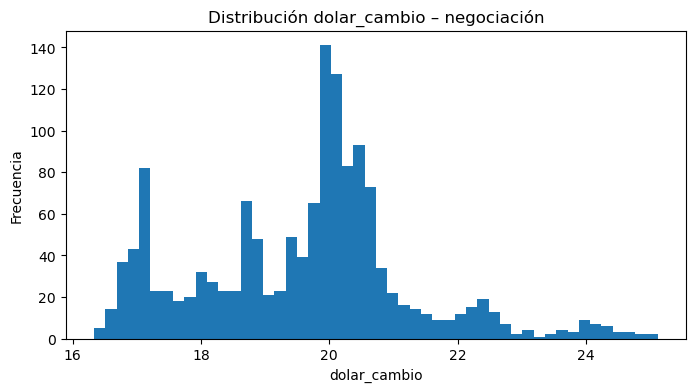

In [65]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución dolar_cambio – negociación')
plt.xlabel('dolar_cambio'); plt.ylabel('Frecuencia')
plt.show()

In [89]:
# La fecha ya viene como índice
df_banxico = df_banxico.copy()
df_banxico.index = pd.to_datetime(df_banxico.index, errors='coerce')
df_banxico = df_banxico.sort_index()
s = df_banxico['tiie_28']

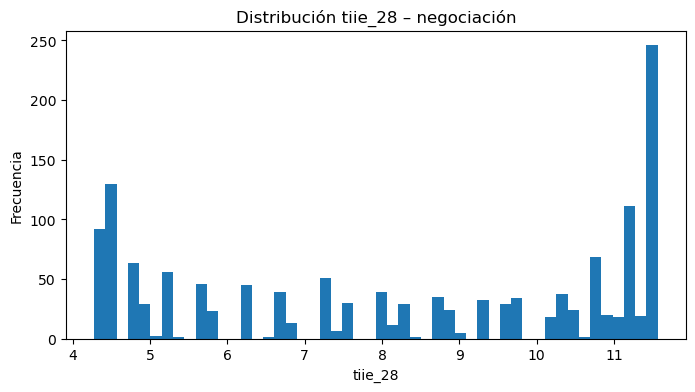

In [90]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución tiie_28 – negociación')
plt.xlabel('tiie_28'); plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# cetes
df_banxico = df_banxico.copy()
df_banxico.index = pd.to_datetime(df_banxico.index, errors='coerce')
df_banxico = df_banxico.sort_index()
s = df_banxico['cetes_28']

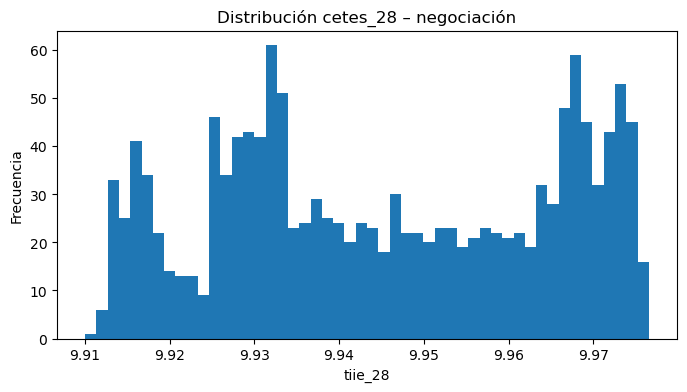

In [101]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución cetes_28 – negociación')
plt.xlabel('tiie_28'); plt.ylabel('Frecuencia')
plt.show()

Las distribuciones del dólar y los CETES presentan una forma irregular y multimodal, lo que sugiere periodos de estabilidad intercalados con ajustes puntuales. En contraste, la TIIE 28 muestra una distribución más dispersa, con picos en los extremos. Estos patrones respaldan la necesidad de un tratamiento individualizado de cada serie antes de aplicar métodos de imputación

### **Analisis Descriptivo**

Es importante el análisis descriptivo porque permite entender la estructura y escala de los datos, detectar errores, outliers y faltantes, guiar transformaciones e imputación adecuadas

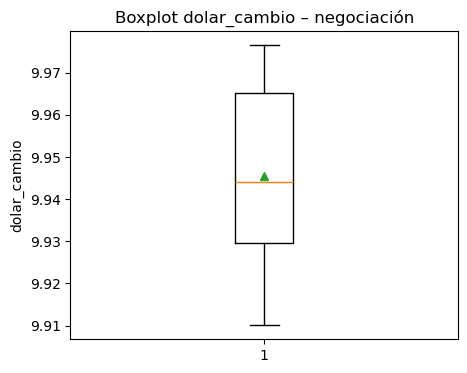

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot([x.values], vert=True, showfliers=True, showmeans=True)
plt.title('Boxplot dolar_cambio – negociación')
plt.ylabel('dolar_cambio')
plt.show()


In [68]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")


count    1428.000000
mean       19.597489
std         1.657030
min        16.335700
25%        18.551275
50%        19.889050
75%        20.440900
max        25.118500
Name: dolar_cambio, dtype: float64
Asimetría (skew): 0.3014
Curtosis (kurt): 0.3731


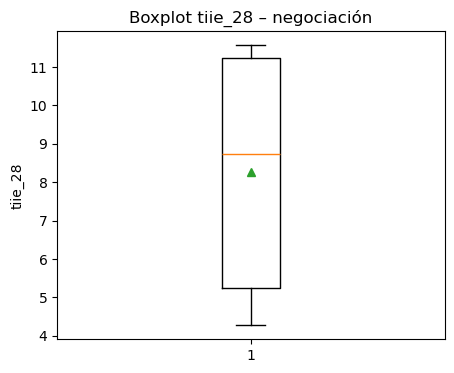

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot([x.values], vert=True, showfliers=True, showmeans=True)
plt.title('Boxplot tiie_28 – negociación')
plt.ylabel('tiie_28')
plt.show()


In [93]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")


count    1428.000000
mean        8.258298
std         2.742947
min         4.274500
25%         5.237650
50%         8.747000
75%        11.240000
max        11.566900
Name: tiie_28, dtype: float64
Asimetría (skew): -0.1737
Curtosis (kurt): -1.5761


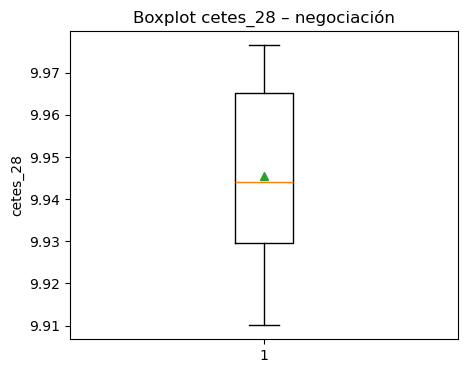

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot([x.values], vert=True, showfliers=True, showmeans=True)
plt.title('Boxplot cetes_28 – negociación')
plt.ylabel('cetes_28')
plt.show()


In [104]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")


count    1428.000000
mean        9.945504
std         0.019318
min         9.910054
25%         9.929502
50%         9.944161
75%         9.965302
max         9.976531
Name: cetes_28, dtype: float64
Asimetría (skew): 0.0012
Curtosis (kurt): -1.3396


 Los resultados evidencian comportamientos diferenciados: el tipo de cambio presenta una distribución ligeramente sesgada a la derecha con valores atípicos en la parte superior, reflejando episodios de volatilidad cambiaria. La TIIE_28 muestra una alta dispersión y colas delgadas, consistente con los ajustes graduales de la política monetaria. En contraste, los CETES_28 presentan una distribución concentrada y casi simétrica , con baja variabilidad, lo que sugiere estabilidad en las tasas de corto plazo.


### **Evaluación de normalidad y colas**

Esta seccion se aplico para cada variable y en niveles, transformaciones logaritmicas y transformaciones de retornos logaritmicos

#### **Dolar Cambio**

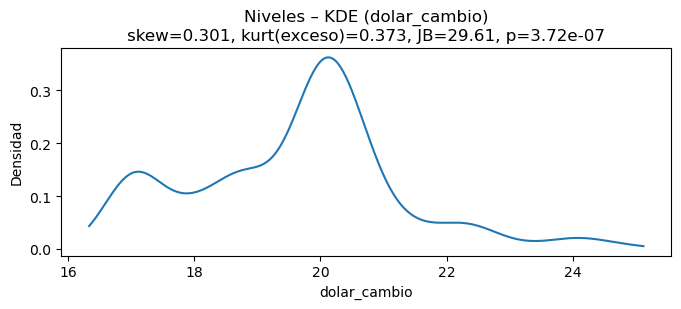

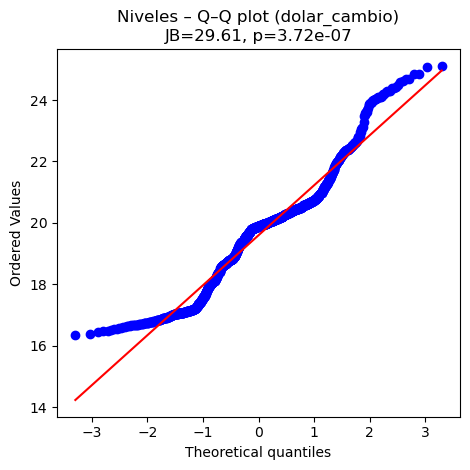

[Niveles / dolar_cambio] skew=0.3014, kurt(exceso)=0.3731, JB=29.6099, p=3.71782e-07, n=1428


In [69]:
plot_kde_qq_levels(s)

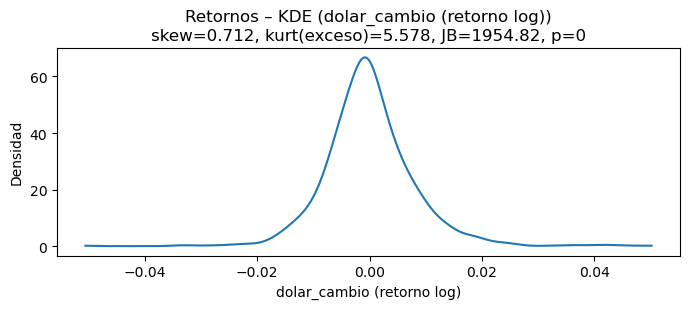

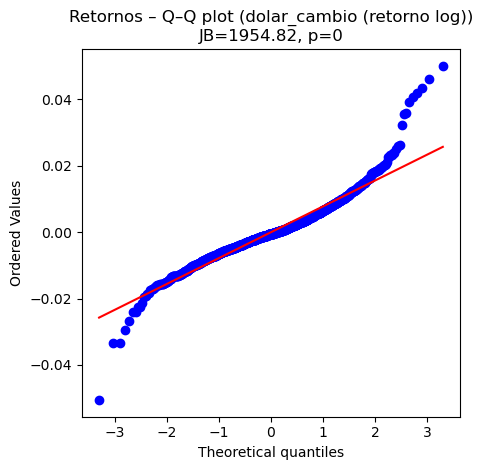

[Retornos / dolar_cambio (retorno log)] skew=0.7120, kurt(exceso)=5.5783, JB=1954.8239, p=0, n=1427


In [43]:
plot_kde_qq_returns(s, mode="log")  

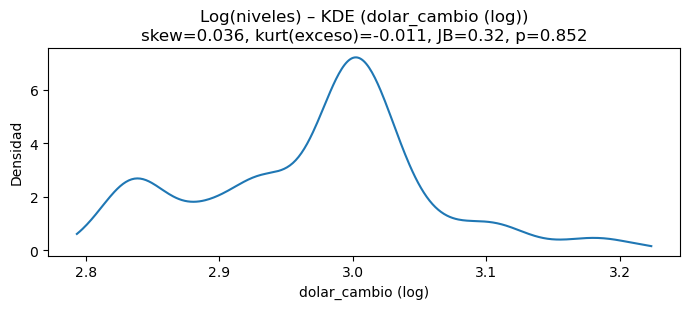

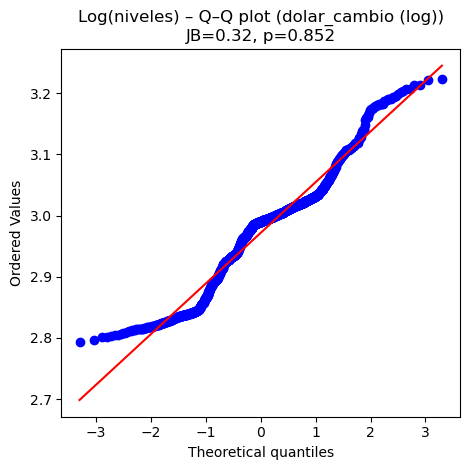

[Log(niveles) / dolar_cambio (log)] skew=0.0359, kurt(exceso)=-0.0113, JB=0.3199, p=0.852201, n=1428


In [70]:
plot_kde_qq_log_levels(s)


El dólar_cambio, el KDE en niveles revela una distribución multimodal y asimétrica, lo que refleja distintos regímenes cambiarios, como se aprecia en los Q-Q plots. Tras aplicar la transformación logarítmica, la forma se vuelve más homogénea, aunque persisten ligeras desviaciones de normalidad. En los retornos simples, la distribución se centra en cero y presenta colas moderadas, coherentes con episodios de volatilidad. 

#### **tiie_28**

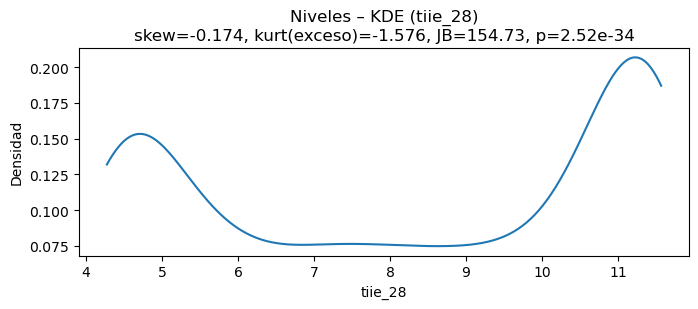

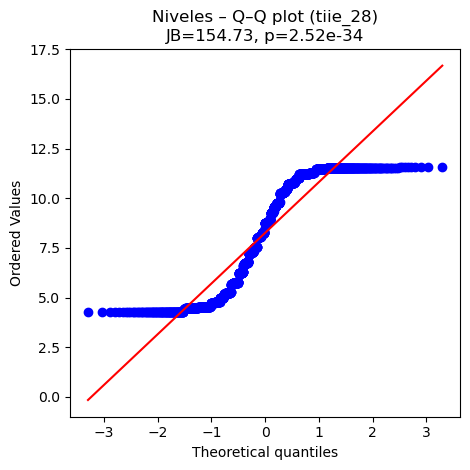

[Niveles / tiie_28] skew=-0.1737, kurt(exceso)=-1.5761, JB=154.7268, p=2.52056e-34, n=1428


In [94]:
plot_kde_qq_levels(s)

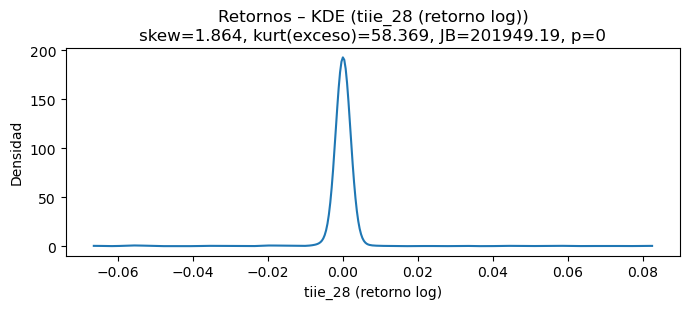

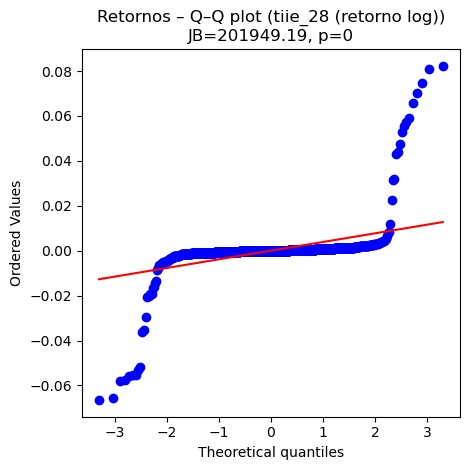

[Retornos / tiie_28 (retorno log)] skew=1.8640, kurt(exceso)=58.3688, JB=201949.1858, p=0, n=1427


In [95]:
plot_kde_qq_returns(s, mode="log")  

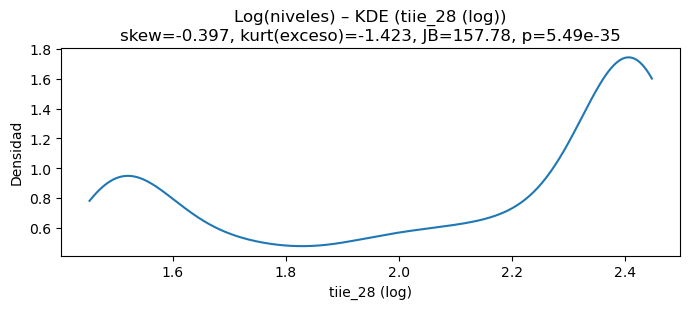

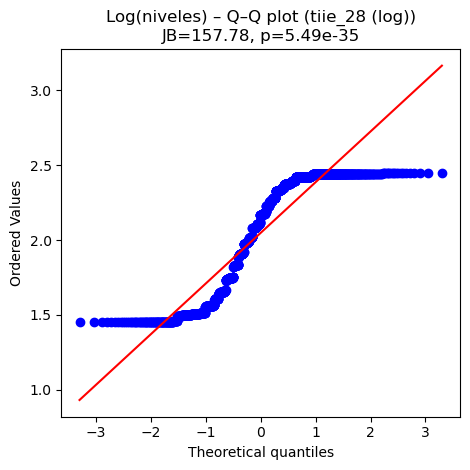

[Log(niveles) / tiie_28 (log)] skew=-0.3967, kurt(exceso)=-1.4233, JB=157.7753, p=5.48943e-35, n=1428


In [96]:
plot_kde_qq_log_levels(s)


La serie TIIE_28, el KDE en niveles y log(precio) muestra una distribución bimodal con fuerte no normalidad. En contraste, los retornos presentan una distribución más centrada y simétrica, aunque con colas pronunciadas, reflejando episodios de alta volatilidad. 


#### **CETES_28**

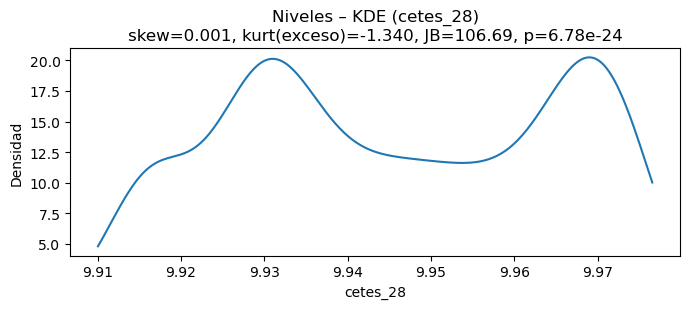

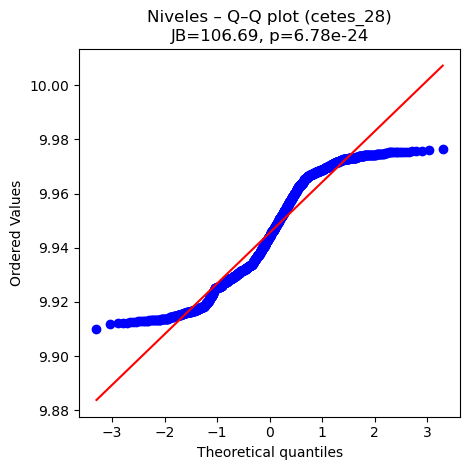

[Niveles / cetes_28] skew=0.0012, kurt(exceso)=-1.3396, JB=106.6947, p=6.78491e-24, n=1428


In [105]:
plot_kde_qq_levels(s)

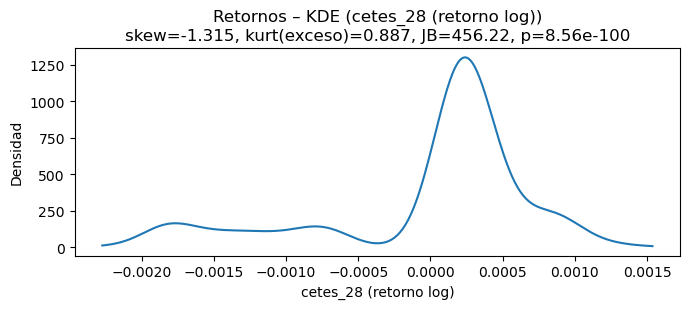

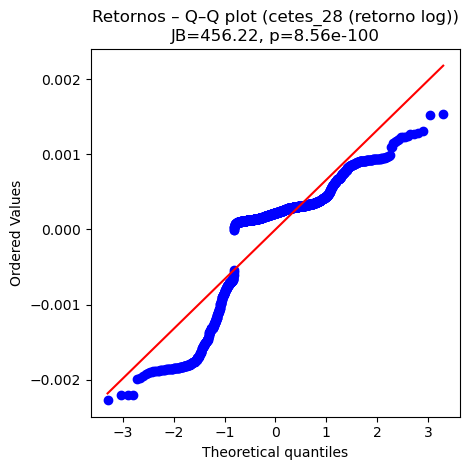

[Retornos / cetes_28 (retorno log)] skew=-1.3147, kurt(exceso)=0.8873, JB=456.2236, p=8.55667e-100, n=1427


In [106]:
plot_kde_qq_returns(s, mode="log")  

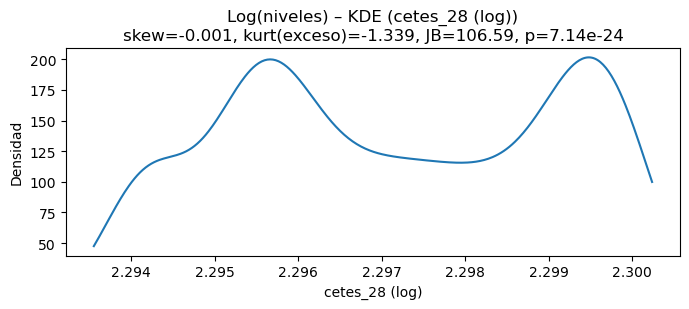

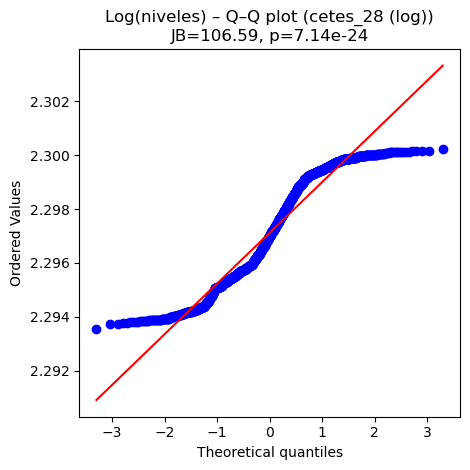

[Log(niveles) / cetes_28 (log)] skew=-0.0007, kurt(exceso)=-1.3389, JB=106.5920, p=7.1423e-24, n=1428


In [107]:
plot_kde_qq_log_levels(s)


Para CETES_28, el KDE en log(precio) muestra bimodalidad y el Q-Q plot evidencia desviaciones de normalidad. En contraste, los retornos presentan una distribución más concentrada y simétrica alrededor de cero.

### **Tendencia**

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= utilidades básicas =========
def _clean_series_indexed(s: pd.Series) -> pd.Series:
    """Index datetime, numérico, sin NaN/Inf."""
    s = s.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors='coerce')
    s = s.sort_index()
    s = pd.to_numeric(s, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
    s.name = s.name or "variable"
    return s

def _rolling_trend(x: pd.Series, window: int = 60, center: bool = True, how: str = "mean") -> pd.Series:
    """
    Tendencia por ventana móvil.
    how: 'mean' (media) o 'median' (mediana robusta).
    """
    window = max(int(window), 3)
    if how == "median":
        trend = x.rolling(window=window, center=center, min_periods=max(3, window//3)).median()
    else:
        trend = x.rolling(window=window, center=center, min_periods=max(3, window//3)).mean()
    return trend

def _plot_trend(x: pd.Series, trend: pd.Series, title: str, ylabel: str):
    plt.figure(figsize=(9,4))
    plt.plot(x.index, x.values, alpha=0.45, label='Serie')
    plt.plot(trend.index, trend.values, linewidth=2.2, label='Tendencia')
    plt.title(title)
    plt.xlabel("Fecha"); plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout(); plt.show()

# ========= 1) NIVELES =========
def plot_trend_levels(s: pd.Series, window: int = 60, center: bool = True, how: str = "mean"):
    """
    Grafica la serie en niveles y su tendencia rolling.
    window: tamaño de ventana
    center: True → ventana centrada
    how: 'mean' o 'median'
    """
    x = _clean_series_indexed(s)
    trend = _rolling_trend(x, window=window, center=center, how=how)
    _plot_trend(x, trend, title=f"Tendencia – niveles: {x.name}", ylabel=x.name)

# ========= 2) RETORNOS LOG =========
def plot_trend_log_returns(s: pd.Series, window: int = 60, center: bool = True, how: str = "mean"):
    """
    Grafica retornos log (diff(log)) y su tendencia rolling.
    """
    s = _clean_series_indexed(s)
    r = np.log(s).diff().dropna()
    r.name = (s.name or "variable") + " (ret log)"
    trend = _rolling_trend(r, window=window, center=center, how=how)
    _plot_trend(r, trend, title=f"Tendencia – retornos log: {s.name}", ylabel="retorno log")

# ========= 3) LOG(NIVELES) =========
def plot_trend_log_levels(s: pd.Series, window: int = 60, center: bool = True, how: str = "mean"):
    """
    Grafica log(niveles) y su tendencia rolling.
    """
    s = _clean_series_indexed(s).replace(0, np.nan).dropna()
    x = np.log(s)
    x.name = (s.name or "variable") + " (log)"
    trend = _rolling_trend(x, window=window, center=center, how=how)
    _plot_trend(x, trend, title=f"Tendencia – log(niveles): {s.name}", ylabel="log(niveles)")


#### **Dolar Cambio**

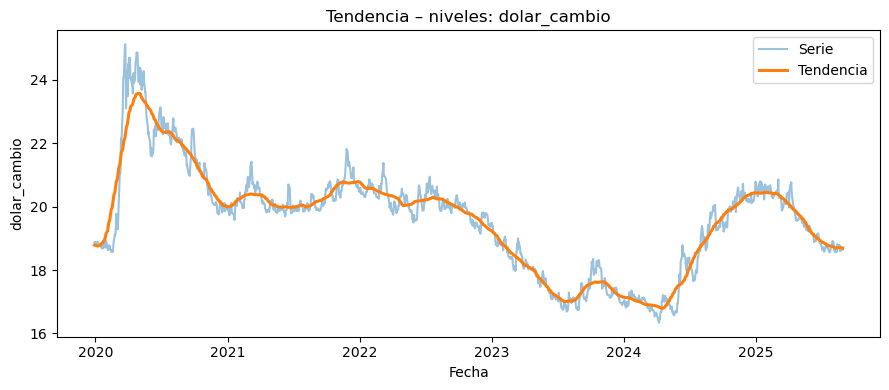

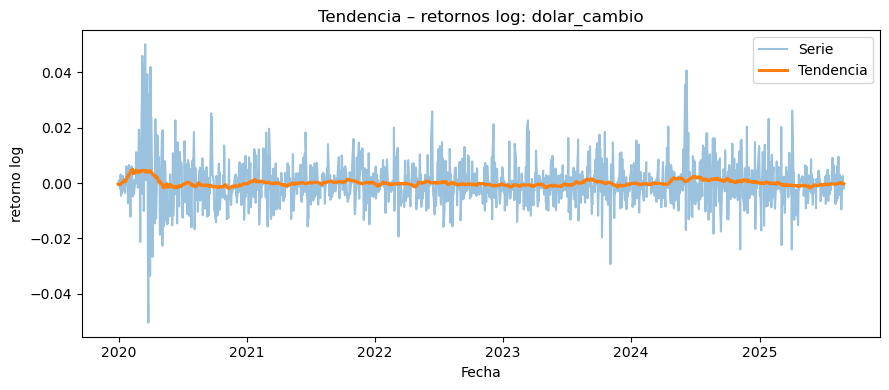

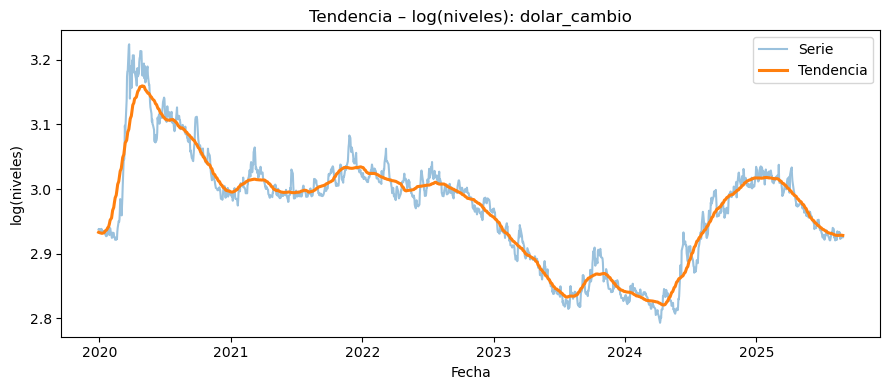

In [72]:
plot_trend_levels(s, window=60)            # niveles
plot_trend_log_returns(s, window=60)       # retornos log
plot_trend_log_levels(s, window=60)        # log(niveles)



En el tipo de cambio (dolar_cambio) observamos una trayectoria en niveles con ciclos marcados: un máximo a inicios de 2020, una fase descendente hasta mediados de 2023 y una recuperación posterior durante 2024–2025. Al trabajar en log-niveles la tendencia se vuelve más suave y proporcional, lo que confirma que esta transformación es adecuada para el análisis e imputación. Los retornos log se mantienen centrados alrededor de cero sin tendencia sistemática, reflejando que la dinámica relevante está en los niveles y no en las diferencias. Dado que los huecos son de 1–2 días como máximo y la tendencia en log es estable, imputaremos en log-niveles

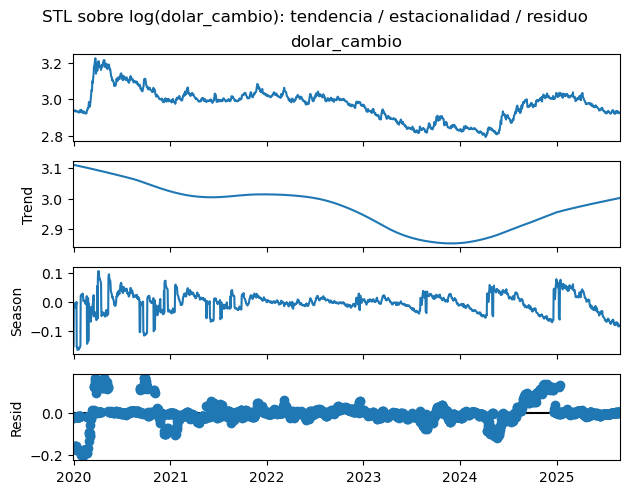

Fuerza de tendencia (STL, sobre log(dolar_cambio)): 0.676


In [76]:
series_for_stl = (log_s.asfreq('D')
                        .interpolate('time')   # interpola suave en huecos
                        .bfill().ffill())

stl = STL(series_for_stl, period=252, robust=True)
res = stl.fit()

# --- Gráfica ---
fig = res.plot()
plt.suptitle('STL sobre log(dolar_cambio): tendencia / estacionalidad / residuo', y=1.02)
plt.show()


var_total = np.var(series_for_stl.values, ddof=0)
var_resid = np.var(res.resid.dropna().values, ddof=0)
trend_strength = 1 - (var_resid / var_total)

print(f"Fuerza de tendencia (STL, sobre log(dolar_cambio)): {trend_strength:.3f}")

El STL revela que la serie en log presenta una tendencia clara (caída hasta 2023 y recuperación después), una estacionalidad débil y residuos acotados alrededor de cero. Esto confirma que la dinámica principal es tendencial y que la imputación en log-niveles no afecta la estructura del dato.

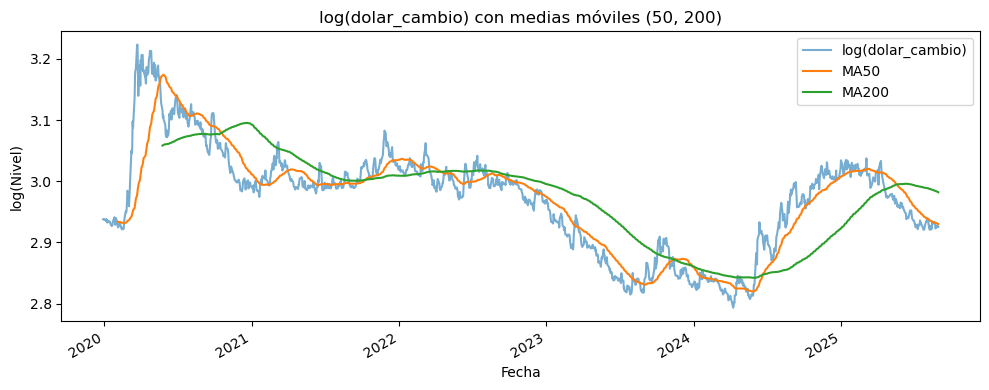

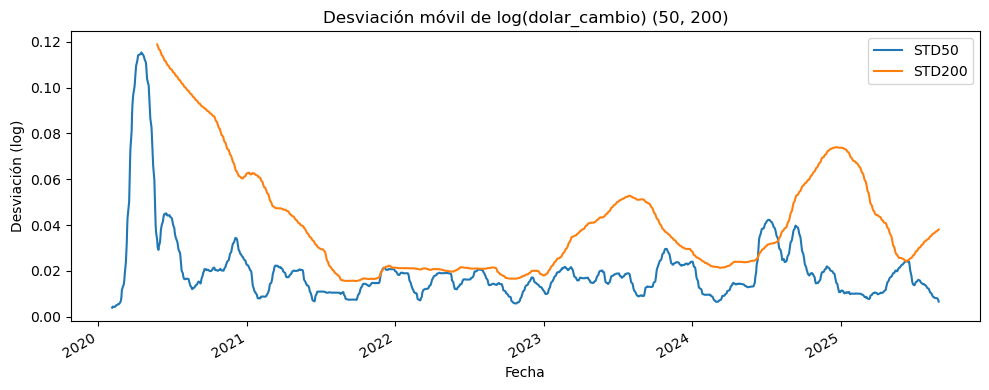

In [74]:
s = df_banxico['dolar_cambio'].copy()

# Limpieza mínima y aseguramos índice de fechas ordenado

if not isinstance(s.index, pd.DatetimeIndex):
    s.index = pd.to_datetime(s.index, errors='coerce')
s = (pd.to_numeric(s, errors='coerce')
       .replace([np.inf, -np.inf], np.nan)
       .dropna()
       .sort_index())


# La serie debe ser estrictamente positiva para usar log
assert (s > 0).all(), "La serie debe ser positiva para usar log."
log_s = np.log(s)

# --- rollings: medias y desviaciones de log(niveles) ---
rolls = {}
for w in [50, 200]:

    ma  = log_s.rolling(window=w, min_periods=w//2).mean()
    std = log_s.rolling(window=w, min_periods=w//2).std()


    rolls[f"ma{w}"]  = ma
    rolls[f"std{w}"] = std

# --- Gráficas ---
plt.figure(figsize=(10,4))
log_s.plot(alpha=0.6)
rolls["ma50"].plot()
rolls["ma200"].plot()
plt.title('log(dolar_cambio) con medias móviles (50, 200)')
plt.legend(['log(dolar_cambio)','MA50','MA200'])
plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
rolls["std50"].plot()
rolls["std200"].plot()
plt.title('Desviación móvil de log(dolar_cambio) (50, 200)')
plt.legend(['STD50','STD200'])
plt.ylabel('Desviación (log)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()


Las medias móviles en log confirman los ciclos ya observados: la MA50 y la MA200 capturan la caída prolongada hasta 2023 y el repunte posterior en 2024–2025, sin rupturas bruscas. La desviación móvil muestra alta volatilidad únicamente al inicio del periodo (2020) y luego se estabiliza en niveles bajos, lo que indica que la serie mantiene variación controlada en log.

#### **TIEE**

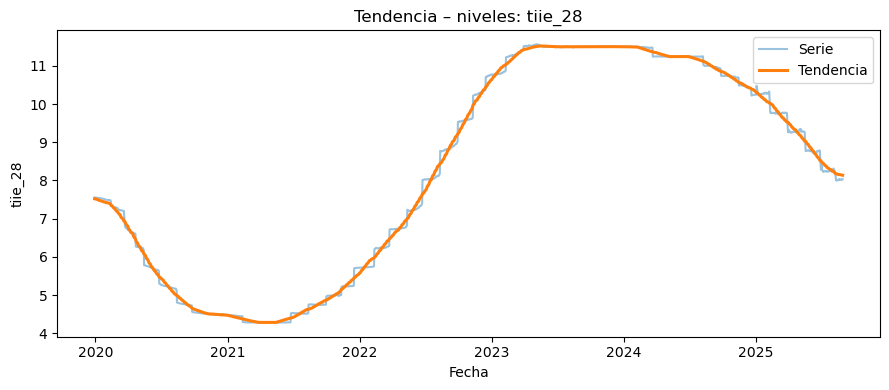

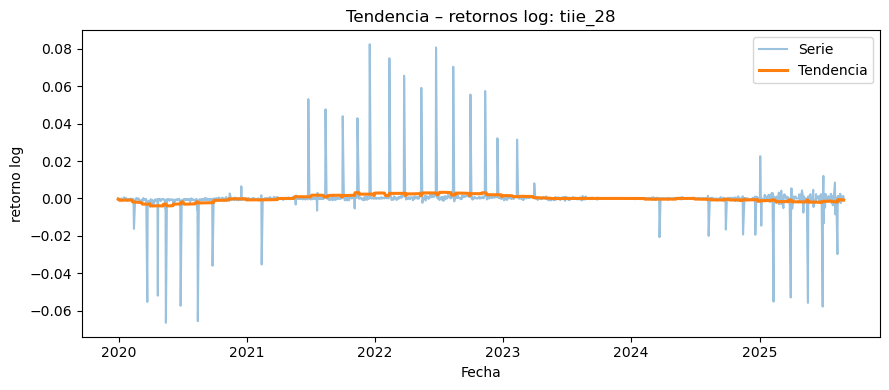

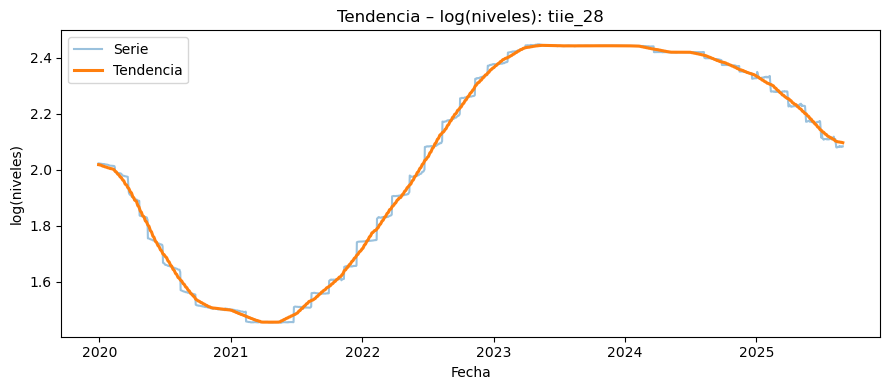

In [97]:
plot_trend_levels(s, window=60)            # niveles
plot_trend_log_returns(s, window=60)       # retornos log
plot_trend_log_levels(s, window=60)        # log(niveles)



La TIIE-28 muestra una trayectoria clara: baja hasta 2021, sube con fuerza hasta 2023 y luego desciende gradualmente. La versión en log conserva la misma forma suavizada y los retornos log no presentan tendencia. Al ser una tasa que cambia por saltos, la imputación adecuada para huecos de 1–2 días es LOCF

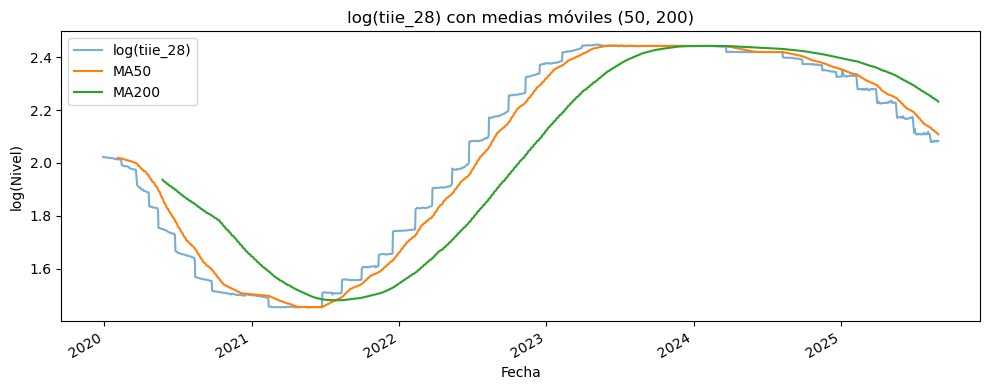

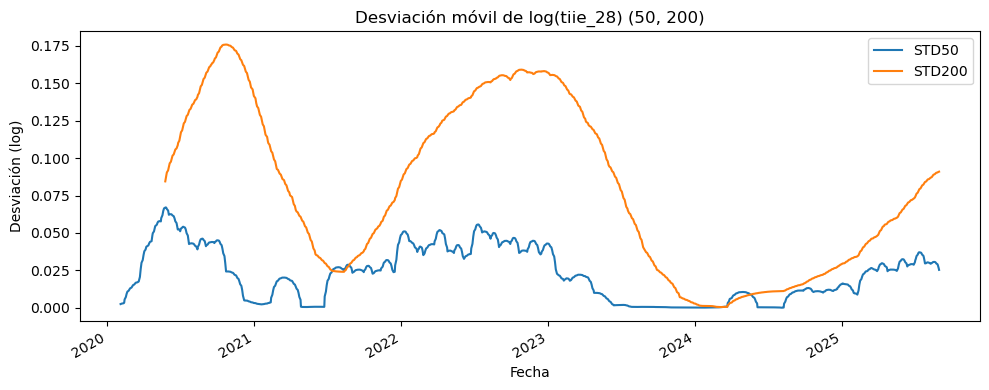

In [98]:

s = df_banxico['tiie_28'].copy()


if not isinstance(s.index, pd.DatetimeIndex):
    s.index = pd.to_datetime(s.index, errors='coerce')
s = (pd.to_numeric(s, errors='coerce')
       .replace([np.inf, -np.inf], np.nan)
       .dropna()
       .sort_index())

assert (s > 0).all(), "La serie debe ser positiva para usar log."
log_s = np.log(s)
rolls = {}
for w in [50, 200]:
    ma  = log_s.rolling(window=w, min_periods=w//2).mean()
    std = log_s.rolling(window=w, min_periods=w//2).std()

    rolls[f"ma{w}"]  = ma
    rolls[f"std{w}"] = std

# --- Gráficas ---
plt.figure(figsize=(10,4))
log_s.plot(alpha=0.6)
rolls["ma50"].plot()
rolls["ma200"].plot()
plt.title('log(tiie_28) con medias móviles (50, 200)')
plt.legend(['log(tiie_28)','MA50','MA200'])
plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
rolls["std50"].plot()
rolls["std200"].plot()
plt.title('Desviación móvil de log(tiie_28) (50, 200)')
plt.legend(['STD50','STD200'])
plt.ylabel('Desviación (log)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()


Las medias y desviaciones móviles confirman el mismo comportamiento suave y escalonado de la TIIE-28: cambios lentos en tendencia y baja variación en log

#### **Cetes_28**

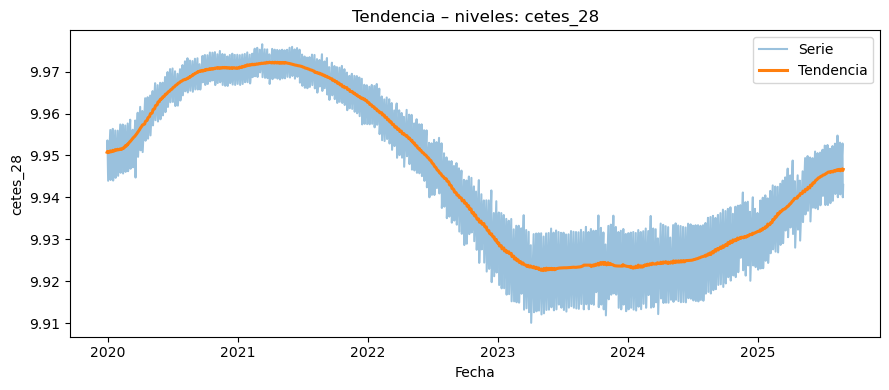

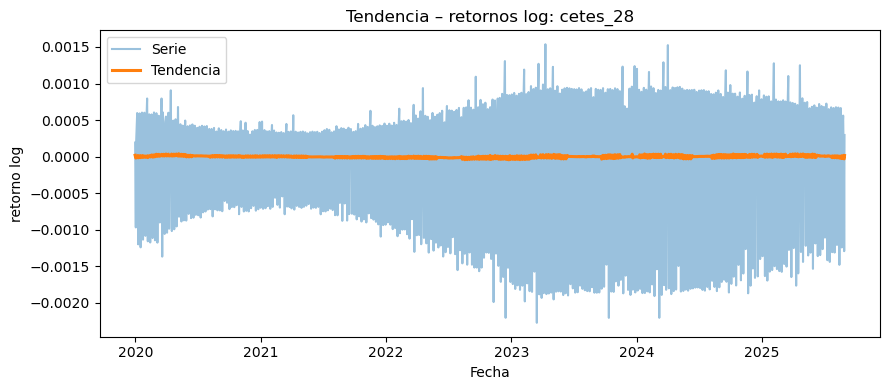

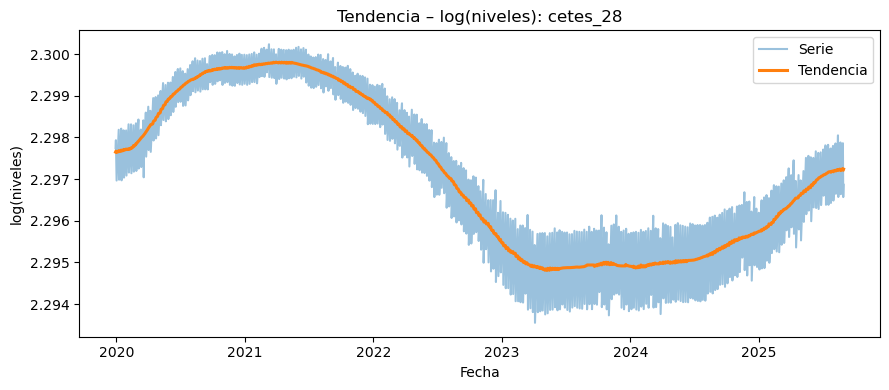

In [108]:
plot_trend_levels(s, window=60)            # niveles
plot_trend_log_returns(s, window=60)       # retornos log
plot_trend_log_levels(s, window=60)        # log(niveles)



En los CETES-28 observamos una variación muy acotada: leve aumento hasta 2021, descenso hasta 2023 y recuperación moderada después. La versión en log reproduce el mismo patrón y los retornos log permanecen centrados en cero sin tendencia. Dado que es una tasa que también cambia por saltos pequeños y frecuentes

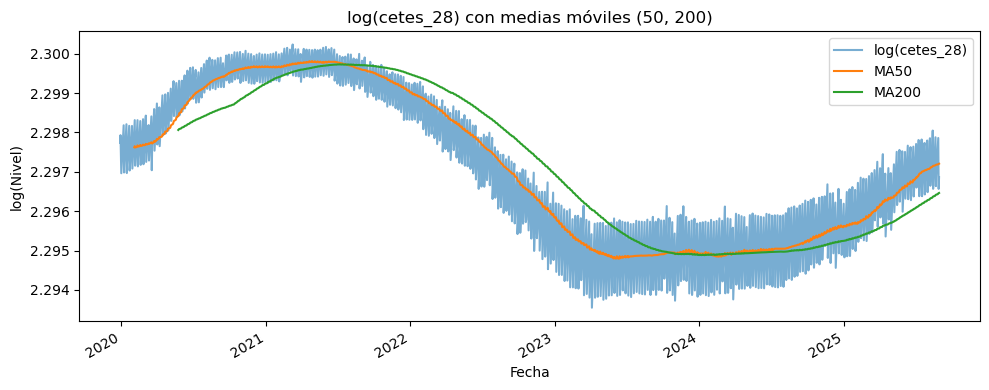

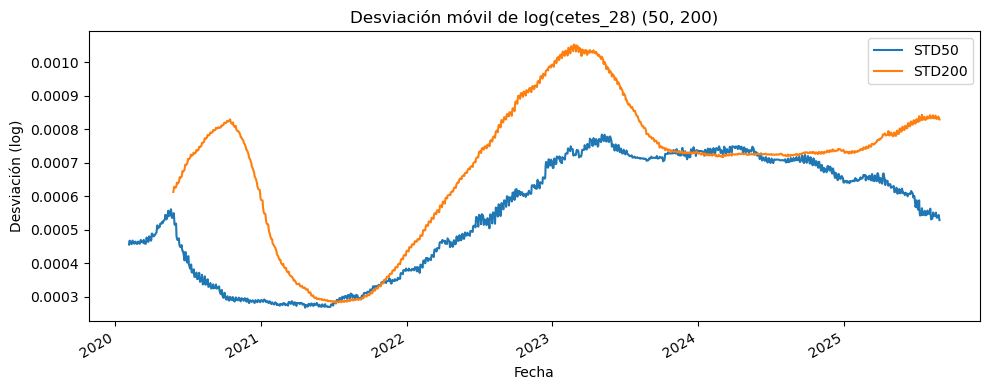

In [109]:
s = df_banxico['cetes_28'].copy()

# Limpieza mínima y aseguramos índice de fechas ordenado
if not isinstance(s.index, pd.DatetimeIndex):
    s.index = pd.to_datetime(s.index, errors='coerce')
s = (pd.to_numeric(s, errors='coerce')
       .replace([np.inf, -np.inf], np.nan)
       .dropna()
       .sort_index())

assert (s > 0).all(), "La serie debe ser positiva para usar log."
log_s = np.log(s)
rolls = {}
for w in [50, 200]:
    ma  = log_s.rolling(window=w, min_periods=w//2).mean()
    std = log_s.rolling(window=w, min_periods=w//2).std()

    rolls[f"ma{w}"]  = ma
    rolls[f"std{w}"] = std

# --- Gráficas ---
plt.figure(figsize=(10,4))
log_s.plot(alpha=0.6)
rolls["ma50"].plot()
rolls["ma200"].plot()
plt.title('log(cetes_28) con medias móviles (50, 200)')
plt.legend(['log(cetes_28)','MA50','MA200'])
plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
rolls["std50"].plot()
rolls["std200"].plot()
plt.title('Desviación móvil de log(cetes_28) (50, 200)')
plt.legend(['STD50','STD200'])
plt.ylabel('Desviación (log)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()


Las medias y desviaciones móviles confirman que los CETES-28 presentan cambios suaves y de baja volatilidad en log, con variaciones graduales y sin rupturas bruscas. Al ser una tasa que se ajusta en pequeños saltos, la imputación correcta para huecos de 1–2 días sigue siendo LOCF, ya que interpolar no aportaría información real y podría distorsionar el comportamiento escalonado de la serie.

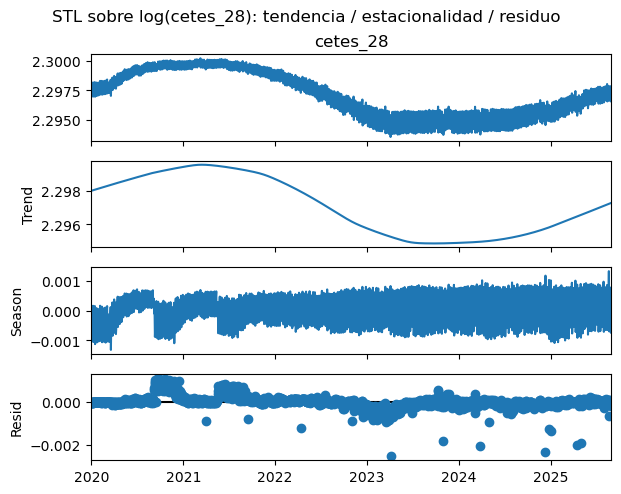

Fuerza de tendencia (STL, sobre log(cetes_28)): 0.977


In [110]:
series_for_stl = (log_s.asfreq('D')
                        .interpolate('time')   
                        .bfill().ffill())

stl = STL(series_for_stl, period=252, robust=True)
res = stl.fit()

# --- Gráfica ---
fig = res.plot()
plt.suptitle('STL sobre log(cetes_28): tendencia / estacionalidad / residuo', y=1.02)
plt.show()

# --- Fuerza de tendencia (Wang et al., medida común) ---
var_total = np.var(series_for_stl.values, ddof=0)
var_resid = np.var(res.resid.dropna().values, ddof=0)
trend_strength = 1 - (var_resid / var_total)

print(f"Fuerza de tendencia (STL, sobre log(cetes_28)): {trend_strength:.3f}")

El STL muestra que los CETES-28 en log tienen una tendencia suave, una estacionalidad prácticamente nula y residuos pequeños y estables

### **Metodo de imputacion**

Para dolar_cambio imputaremos en log-niveles con interpolación lineal. Para TIIE-28 y CETES-28, por ser tasas que cambian por saltos, aplicaremos LOCF (forward-fill) en huecos cortos. Para UDIS y tasa_ref también utilizaremos LOCF, ya que los nulos observados provienen únicamente de fines de semana al regularizar el calendario.